### 전이 학습(Transfer Learning)
  - 특정 분야에서 학습된 신경망의 일부 능력을 유사하거나 전혀 새로운 분야에서 사용되는 신경망의 학습에 이용하는 것을 의미합니다.
  - 전이 학습은 학습 데이터의 수가 적을때도 효과적이며, 학습 속도도 빠릅니다.  
  
    
  - 전이학습이란 이미지넷과 같이 아주 큰 데이터셋에 훈련된 모델의 가중치를 가지고 와서 우리가 해결하고자 하는 과제에 맞게 재보정해서 사용하는 것을 의미 : https://bskyvision.com/698  
      
      
  - Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. : https://en.wikipedia.org/wiki/Transfer_learning

### 210701 basicTextClassification 참조
  - 앞선 코드와 차이나는 부분만 기술
  - 텐서플로 허브(Tensorflow Hub)와 케라스(Keras)를 사용한 기초적인 전이학습 애플리케이션
  - tf.keras와 전이학습 라이브러리이자 플랫폼인 텐서플로 허브 사용

### 01. 라이브러리 설치

In [1]:
!pip install -q tensorflow-hub
!pip install -q tfds-nightly

### 02. import

In [2]:
import numpy as np
import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [4]:
print('tf version: ', tf.__version__)
print('즉시 실행 모드: ', tf.executing_eagerly())
print('hub version: ', hub.__version__)
# print('GPU', '사용가능', if tf.config.experimental.list_physical_device('GPU'))

tf version:  2.5.0
즉시 실행 모드:  True
hub version:  0.12.0


### 03. Dataset Download
  - train_data : 25000
    - train_data : 60%
    - validation_data : 40%
  - test_data : 25000

In [6]:
train_data, validation_data, test_data = tfds.load(
    name='imdb_reviews',
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to C:\Users\jjanh_000\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


#### 데이터 탐색

In [7]:
# 처음 데이터 10개를 출력
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [8]:
# 처음 레이블 10개를 출력
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int64)>

### 04. 모델 구성
  - 모델 구조 결정
    - 어떻게 텍스트를 표현할 것인가?
    - 모델에서 얼마나 많은 층을 사용할 것인가?
    - 각 층에서 얼마나 많은 은닉 유닛(hidden unit)을 사용할 것인가?  
      
  - 임베딩(embedding) 벡터로 바꾸는 방법 : 사전 훈련(pre-trained)된 텍스트 임베딩 사용
    - 텍스트 전처리에 대해 신경쓸 필요가 없습니다.
    - 전이 학습의 장점을 이용합니다.
    - 임베딩은 고정 크기이기 때문에 처리 과정이 단순해집니다.  
      
  - google/tf2-preview/gnews-swivel-dodim/1 : pre-trained text embedding model 사용  
    
      
  - pre-trained model
    - google/tf2-preview/gnews-swivel-20dim-with-oov/1 - google/tf2-preview/gnews-swivel-20dim/1와 동일하지만 어휘 사전(vocabulary)의 2.5%가 OOV 버킷(bucket)으로 변환되었습니다. 이는 해당 문제의 어휘 사전과 모델의 어휘 사전이 완전히 겹치지 않을 때 도움이 됩니다.
    - google/tf2-preview/nnlm-en-dim50/1 - 더 큰 모델입니다. 차원 크기는 50이고 어휘 사전의 크기는 1백만 개 이하입니다.
    - google/tf2-preview/nnlm-en-dim128/1 - 훨씬 더 큰 모델입니다. 차원 크기는 128이고 어휘 사전의 크기는 1백만 개 이하입니다.

In [9]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                          dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

#### 전체 모델
  - 첫 번째 층 : 텐서플로우 허브 층
    - 사전훈련된 모델을 사용 : 문장 하나를 임베딩 벡터로 매핑
    - google/tf2-preview/gnews-swivel-20dim/1 : 문장 하나를 토큰(token)으로 나누고 각 토큰의 임베딩을 연결하여 반환
    - 출력 차원 : (num_examples, embedding_dimension)
    
  - 두 번째 층 : fully-connected layer
    - hidden unit : 16
    
  - 마지막 층 : 출력노드 하나인 fully-connected layer
    - sigmoid 활정화 함수를 사용 : 확률 / 신뢰도 수준
    - 0~1 사이의 실수가 출력

In [10]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


### 05. 모델 컴파일
  - 손실함수와 옵티마이저

In [11]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

### 06. 모델 훈련
  - mini-batch : 512
  - epochs : 20

In [12]:
history = model.fit(train_data.shuffle(10000).batch(512),
                   epochs=20,
                   validation_data=validation_data.batch(512),
                   verbose=1)

Epoch 1/20
30/30 [==============================] - 14s 230ms/step - loss: 0.7927 - accuracy: 0.4848 - val_loss: 0.7148 - val_accuracy: 0.5343
Epoch 2/20
30/30 [==============================] - 6s 181ms/step - loss: 0.6688 - accuracy: 0.5737 - val_loss: 0.6324 - val_accuracy: 0.6062
Epoch 3/20
30/30 [==============================] - 6s 182ms/step - loss: 0.6111 - accuracy: 0.6336 - val_loss: 0.5951 - val_accuracy: 0.6420
Epoch 4/20
30/30 [==============================] - 5s 177ms/step - loss: 0.5765 - accuracy: 0.6645 - val_loss: 0.5647 - val_accuracy: 0.6861
Epoch 5/20
30/30 [==============================] - 5s 181ms/step - loss: 0.5413 - accuracy: 0.7031 - val_loss: 0.5316 - val_accuracy: 0.7171
Epoch 6/20
30/30 [==============================] - 6s 181ms/step - loss: 0.5040 - accuracy: 0.7382 - val_loss: 0.4992 - val_accuracy: 0.7281
Epoch 7/20
30/30 [==============================] - 6s 185ms/step - loss: 0.4657 - accuracy: 0.7669 - val_loss: 0.4649 - val_accuracy: 0.7749
Epoch

### 07. 모델 평가

In [13]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" %(name, value))

49/49 - 6s - loss: 0.3225 - accuracy: 0.8555
loss: 0.322
accuracy: 0.855


### 08. 정확도와 손실 그래프
  - history 객체 : 훈련하는 동안 일어난 모든 정보가 담긴 자료가 포함

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

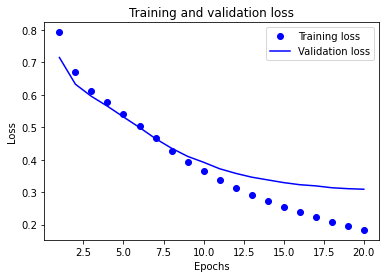

In [15]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 'bo' 는 파란색 점 입니다.
plt.plot(epochs, loss, 'bo', label='Training loss')

# 'b'는 파란 실선 입니다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

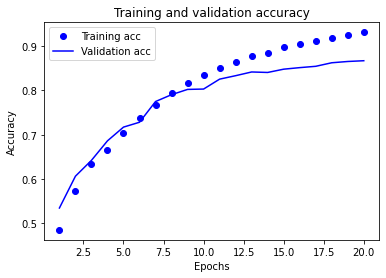

In [16]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()